<h1>Define headers</h1>

In [9]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode

# import some common libraries
import numpy as np
import cv2
import random
import os
import json
import time
import statistics 
import math  

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D


from PIL import Image

import torch
torch.cuda.set_device(0)

<h1> Define Dataset</h1>

In [10]:
def get_ball_dicts():
    txt_file = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "open_images.txt")
    f = open(txt_file, "r")
    c=0
    dataset_dicts = []
    
    for line in f:
        record = {}
        objs = []
        c+=1

        filename=line[49+4:69+4]
        width, height = Image.open(os.path.join("/home/danielarato/ball_detection/Datasets/train/Ball/", filename)).size

        record["file_name"] = os.path.join("/home/danielarato/ball_detection/Datasets/train/Ball/", filename)
        record["image_id"] = c
        record["height"] = height
        record["width"] = width

        label_txt="/home/danielarato/ball_detection/Datasets/train/Label/"+filename[:16]+".txt"
        f_label = open(label_txt, "r")

        for line_label in f_label:
            px=[]
            py=[]
            x = line_label.split()
            px.append(float(x[1]))
            px.append(float(x[3]))
            py.append(float(x[2]))
            py.append(float(x[4]))
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)    
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

def get_ball_dicts_grayscale():
    txt_file = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "open_images_grayscale.txt")
    f = open(txt_file, "r")
    c=0
    dataset_dicts = []
    
    for line in f:
        record = {}
        objs = []
        c+=1

        filename=line[49+4+1:69+4+1]
        width, height = Image.open(os.path.join("/home/danielarato/ball_detection/Datasets/train/Grayscale/", filename)).size

        record["file_name"] = os.path.join("/home/danielarato/ball_detection/Datasets/train/Grayscale/", filename)
        record["image_id"] = c
        record["height"] = height
        record["width"] = width

        label_txt="/home/danielarato/ball_detection/Datasets/train/Label/"+filename[:16]+".txt"
        f_label = open(label_txt, "r")

        for line_label in f_label:
            px=[]
            py=[]
            x = line_label.split()
            px.append(float(x[1]))
            px.append(float(x[3]))
            py.append(float(x[2]))
            py.append(float(x[4]))
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)    
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


from detectron2.data import DatasetCatalog, MetadataCatalog
DatasetCatalog.register("Ball_train", lambda:get_ball_dicts())
MetadataCatalog.get("Ball_train").set(thing_classes=["Ball"])
ball_metadata = MetadataCatalog.get("Ball_train")


DatasetCatalog.register("Ball_train_bw", lambda:get_ball_dicts_grayscale())
MetadataCatalog.get("Ball_train_bw").set(thing_classes=["Ball"])
ball_metadata = MetadataCatalog.get("Ball_train_bw")

AssertionError: Dataset 'Ball_train' is already registered!

<h1>Confirm if datasets works</h1>

In [ ]:
import random 
import matplotlib.pyplot as plt
dataset_dicts = get_ball_dicts_grayscale()
ball_metadata = MetadataCatalog.get("Ball_train_bw")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=ball_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image()[:, :, ::-1])
    


In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"))
cfg.DATASETS.TRAIN = ("Ball_train_bw",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 7000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("ball_train", )
predictor = DefaultPredictor(cfg)

In [11]:
# cameraMatrix=[[708.30536, 0, 170.51079],
#  [0, 714.59424, 130.0705],
#  [0, 0, 1]]
d_real=0.63 *1000#mm

cameraMatrix_IR=np.array([[725.790155, 0, 191.397201],
[0, 733.580771, 149.464123],
[0, 0, 1]])

cameraMatrix_IR=np.array([[705.1735, 0.000000, 172.6855],
                          [0.000000, 710.7784, 148.5702],
                          [0.000000, 0.000000, 1.000000]])

# 708.305362, 0.000000, 170.510788, 0.000000, 714.594222, 130.070494, 0.000000, 0.000000, 1.000000


print(cameraMatrix_IR)

fx=cameraMatrix_IR[0][0]
fy=cameraMatrix_IR[1][1]
cx=cameraMatrix_IR[0][2]
cy=cameraMatrix_IR[1][2]
print(fx,fy,cx,cy)

[[705.1735   0.     172.6855]
 [  0.     710.7784 148.5702]
 [  0.       0.       1.    ]]
705.1735 710.7784 172.6855 148.5702


In [12]:
cameraMatrix_RGB=np.array([[2168.684845,0,965.374725],
[0,2180.313918,699.133011],
[0,0,1]])


cameraMatrix_mono=np.array([[2363.738690444174,0,1072.79004424623],
[0,2370.592662770868, 788.4498446284557],
[0,0,1]])

cameraMatrix_RGB=cameraMatrix_mono

fx_rgb=cameraMatrix_RGB[0][0]
fy_rgb=cameraMatrix_RGB[1][1]
cx_rgb=cameraMatrix_RGB[0][2]
cy_rgb=cameraMatrix_RGB[1][2]
print(fx_rgb,fy_rgb,cx_rgb,cy_rgb)

2363.738690444174 2370.592662770868 1072.79004424623 788.4498446284557


<h1> Plot 3D real points </h1>

207 455


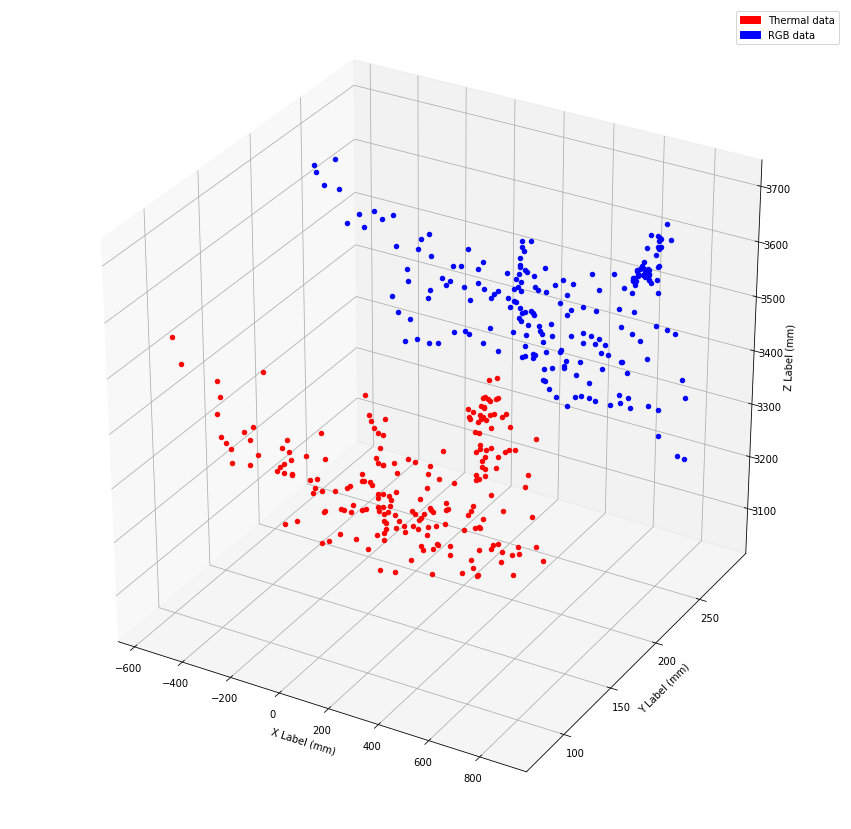

In [8]:
#read txt files with image path
txt_file_rgb =os.path.join("/home/danielarato/ball_detection/Datasets/train/compilation/", "compilation_RGB.txt")
f_rgb = open(txt_file_rgb, "r")

txt_file_ir = os.path.join("/home/danielarato/ball_detection/Datasets/train/compilation/", "compilation_IR.txt")
f_ir = open(txt_file_ir, "r")

#iniciate 3d plot
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d' )
blue_patch = mpatches.Patch(color='blue', label='RGB data')
red_patch = mpatches.Patch(color='red', label='Thermal data')
plt.legend(handles=[red_patch,blue_patch])

ax.set_xlabel('X Label (mm)')
ax.set_ylabel('Y Label (mm)')
ax.set_zlabel('Z Label (mm)')


#initiate vectors
Xt=[]
Yt=[]
Zt=[]
Xr=[]
Yr=[]
Zr=[]
xpi=[]
ypi=[]
xpr=[]
ypr=[]
c=0
c_for=0

#for each figure in the path
for line_rgb in f_rgb: 
    c_for+=1
    # read images and calculate detected bounding box for each camera
    im_rgb = cv2.imread(line_rgb[:len(line_rgb)-1])
    outputs_rgb = predictor(im_rgb)
    results_rgb=outputs_rgb["instances"].to("cpu")
    
    line_ir=f_ir.readline()
    if(line_ir==""):
        break
    im_ir = cv2.imread(line_ir[:len(line_ir)-1])
    outputs_ir = predictor(im_ir)
    results_ir=outputs_ir["instances"].to("cpu")

    # CALCULATE CENTERS - remove images without detection in both timestamp
    if(len(results_rgb)!=0 and len(results_ir)!=0 ):
        coordinates_ir=results_ir.pred_boxes.tensor[0].numpy()
        coordinates_rgb=results_rgb.pred_boxes.tensor[0].numpy()
        
        cond1=(abs((coordinates_rgb[2]-coordinates_rgb[0])-(coordinates_rgb[3]-coordinates_rgb[1]))>=0.07*max((coordinates_rgb[2]-coordinates_rgb[0]),(coordinates_rgb[3]-coordinates_rgb[1])))
        cond2=(abs((coordinates_ir[2]-coordinates_ir[0])-(coordinates_ir[3]-coordinates_ir[1]))>=0.07*max((coordinates_ir[2]-coordinates_ir[0]),(coordinates_ir[3]-coordinates_ir[1])))

        if(cond1==False and cond2==False):
            #VISUAL
            xc_rgb=(coordinates_rgb[2]-coordinates_rgb[0])/2+coordinates_rgb[0]
            yc_rgb=(coordinates_rgb[3]-coordinates_rgb[1])/2+coordinates_rgb[1]
            xc_rgb=float("%0.2f"%xc_rgb)
            yc_rgb=float("%0.2f"%yc_rgb)

            dx_rgb=float("%0.2f"%(float("%0.2f"%coordinates_rgb[2])-float("%0.2f"%coordinates_rgb[0])))
            dy_rgb=float("%0.2f"%(float("%0.2f"%coordinates_rgb[3])-float("%0.2f"%coordinates_rgb[1])))
            d_pix_rgb=(dx_rgb+dy_rgb)/2

            Z_rgb=((fx_rgb+fy_rgb)/2)*(d_real/d_pix_rgb)
            X_rgb=(Z_rgb*(xc_rgb-cx_rgb))/fx_rgb
            Y_rgb=(Z_rgb*(yc_rgb-cy_rgb))/fy_rgb

            ax.scatter(X_rgb, Y_rgb, Z_rgb, c='b') #draw in plot
            #IR
            xc=(coordinates_ir[2]-coordinates_ir[0])/2+coordinates_ir[0]
            yc=(coordinates_ir[3]-coordinates_ir[1])/2+coordinates_ir[1]
            xc=float("%0.2f"%xc)
            yc=float("%0.2f"%yc)

            dx=float("%0.2f"%(float("%0.2f"%coordinates_ir[2])-float("%0.2f"%coordinates_ir[0])))
            dy=float("%0.2f"%(float("%0.2f"%coordinates_ir[3])-float("%0.2f"%coordinates_ir[1])))
            d_pix=(dx+dy)/2

            Z_ir=((fx+fy)/2)*(d_real/d_pix)
            X_ir=(Z_ir*(xc-cx))/fx
            Y_ir=(Z_ir*(yc-cy))/fy
            pix_ir=np.array([xc,yc,1])

            #append points
            Xr.append(X_rgb)
            Yr.append(Y_rgb)
            Zr.append(Z_rgb)
            Xt.append(X_ir)
            Yt.append(Y_ir)
            Zt.append(Z_ir) 
            xpr.append(xc_rgb)
            ypr.append(yc_rgb)
            xpi.append(xc)
            ypi.append(yc)

            ax.scatter(X_ir, Y_ir, Z_ir, c='r') #draw in plot
            
            c+=1
f_ir.close()        
f_rgb.close()
print(c,c_for)

<h1>Plot pixel points vs real distance to ball</h1>

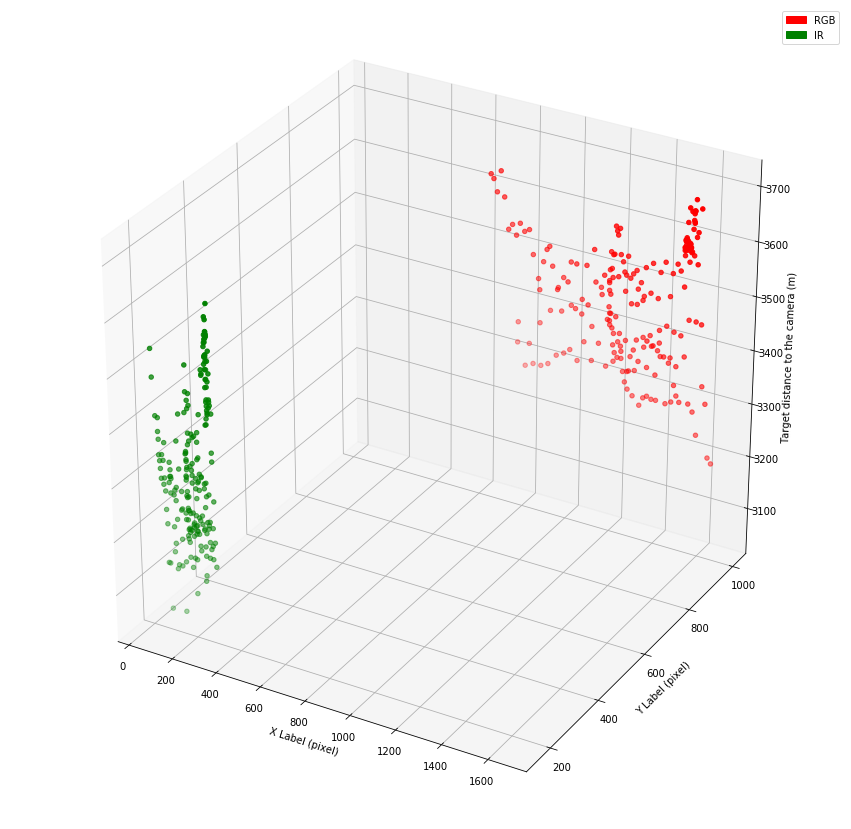

In [9]:
fig3 = plt.figure(figsize=(15,15))
ax3 = fig3.add_subplot(111, projection='3d' )
blue_patch = mpatches.Patch(color='green', label='IR')
red_patch = mpatches.Patch(color='red', label='RGB')
plt.legend(handles=[red_patch,blue_patch])
ax3.set_xlabel('X Label (pixel)')
ax3.set_ylabel('Y Label (pixel)')
ax3.set_zlabel('Target distance to the camera (m)')


ax3.scatter(xpr,ypr,Zr, c='r')
ax3.scatter(xpi,ypi,Zt, c='g')
# print(xpi)
# print(xpr)

<h1>Plot Ball Center in Pixels</h1>

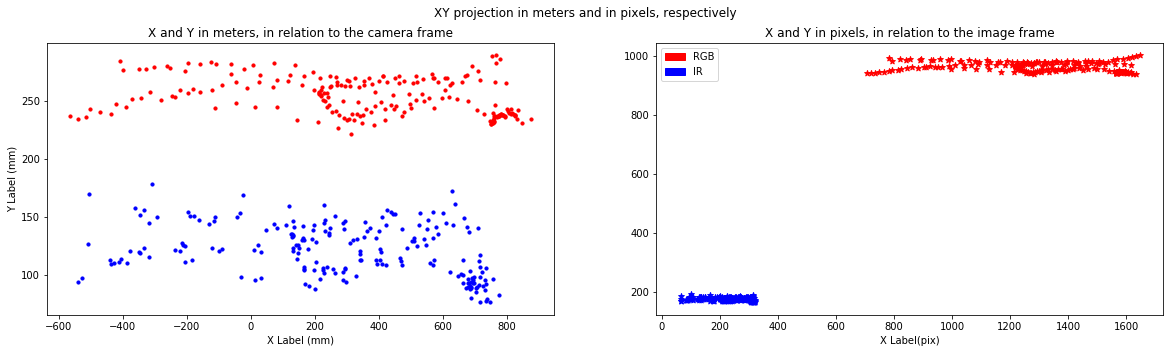

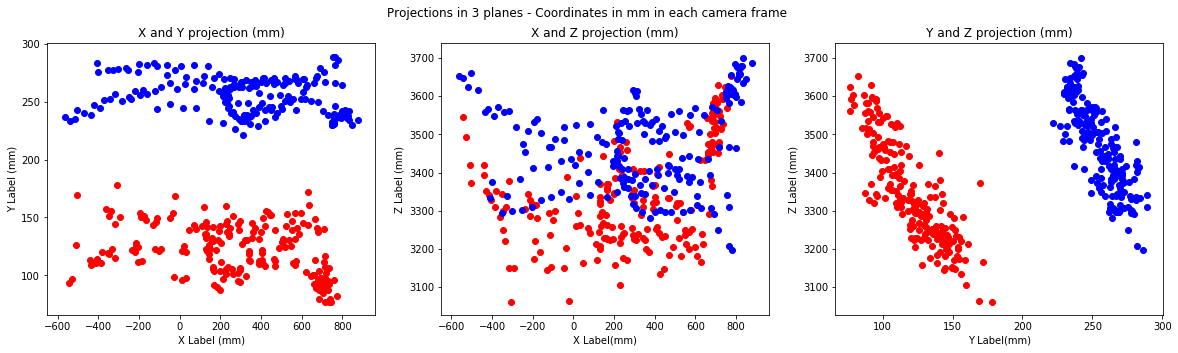

In [10]:
fig0, axs_0 = plt.subplots(1,2,figsize=(20,5))
blue_patch = mpatches.Patch(color='blue', label='IR')
red_patch = mpatches.Patch(color='red', label='RGB')
plt.legend(handles=[red_patch,blue_patch])

fig0.suptitle("XY projection in meters and in pixels, respectively ")

axs_0[0].scatter(Xr,Yr,c='r',s=10)
axs_0[0].scatter(Xt,Yt,c='b',s=10)
axs_0[0].set_xlabel('X Label (mm)')
axs_0[0].set_ylabel('Y Label (mm)')
axs_0[0].set_title('X and Y in meters, in relation to the camera frame')

axs_0[1].scatter(xpr,ypr,c='r',marker="*")
axs_0[1].scatter(xpi,ypi,c='b',marker="*")
axs_0[1].set_xlabel('X Label(pix)')
axs_0[1].set_title('X and Y in pixels, in relation to the image frame')

fig_proj, axs_proj = plt.subplots(1,3,figsize=(20,5))

fig_proj.suptitle("Projections in 3 planes - Coordinates in mm in each camera frame")

axs_proj[0].scatter(Xt,Yt, c='r')
axs_proj[0].scatter(Xr,Yr, c='b')
axs_proj[0].set_xlabel('X Label (mm)')
axs_proj[0].set_ylabel('Y Label (mm)')
axs_proj[0].set_title('X and Y projection (mm)')

axs_proj[1].scatter(Xt, Zt,c='r')
axs_proj[1].scatter(Xr, Zr,c='b')
axs_proj[1].set_xlabel('X Label(mm)')
axs_proj[1].set_ylabel('Z Label (mm)')
axs_proj[1].set_title('X and Z projection (mm)')

axs_proj[2].scatter(Yt,Zt, c='r')
axs_proj[2].scatter(Yr,Zr, c='b')
axs_proj[2].set_xlabel('Y Label(mm)')
axs_proj[2].set_ylabel('Z Label (mm)')
axs_proj[2].set_title('Y and Z projection (mm)')

plt.show()

<h1>Draw images with bounding boxes and legend with coordinates in meters and pixels</h1>

In [2]:
# #read txt files with image path
# txt_file_rgb = os.path.join("/home/danielarato/ball_detection/Datasets/train/huge_bag/", "huge_RGB.txt")
# # txt_file_rgb = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "RGB_camera.txt")
# f_rgb = open(txt_file_rgb, "r")

# # txt_file_ir = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "IR_camera.txt")
# txt_file_ir = os.path.join("/home/danielarato/ball_detection/Datasets/train/huge_bag/", "huge_IR.txt")
# f_ir = open(txt_file_ir, "r")

# #initiate vectors
# Xt=[]
# Yt=[]
# Zt=[]
# Xr=[]
# Yr=[]
# Zr=[]
# xpi=[]
# ypi=[]
# xpr=[]
# ypr=[]
# c=0

# #for each figure in the path
# for line_rgb in f_rgb:
    
#     # read images and calculate detected bounding box for each camera
#     im_rgb = cv2.imread(line_rgb[:len(line_rgb)-1])
#     outputs_rgb = predictor(im_rgb)
#     results_rgb=outputs_rgb["instances"].to("cpu")
    
#     line_ir=f_ir.readline()
#     if(line_ir==""):
#         break
#     im_ir = cv2.imread(line_ir[:len(line_ir)-1])
#     outputs_ir = predictor(im_ir)
#     results_ir=outputs_ir["instances"].to("cpu")


#     # CALCULATE CENTERS - remove images without detection in both timestamp
#     if(len(results_rgb)!=0 and len(results_ir)!=0 ):
#         coordinates_ir=results_ir.pred_boxes.tensor[0].numpy()
#         coordinates_rgb=results_rgb.pred_boxes.tensor[0].numpy()
        
#         cond1=(abs((coordinates_rgb[2]-coordinates_rgb[0])-(coordinates_rgb[3]-coordinates_rgb[1]))>=0.07*max((coordinates_rgb[2]-coordinates_rgb[0]),(coordinates_rgb[3]-coordinates_rgb[1])))
#         cond2=(abs((coordinates_ir[2]-coordinates_ir[0])-(coordinates_ir[3]-coordinates_ir[1]))>=0.07*max((coordinates_ir[2]-coordinates_ir[0]),(coordinates_ir[3]-coordinates_ir[1])))

#         if(cond1==False and cond2==False):
#             fig, axs = plt.subplots(1,2,figsize=(10,5))

#             #VISUAL
#             xc_rgb=(coordinates_rgb[2]-coordinates_rgb[0])/2+coordinates_rgb[0]
#             yc_rgb=(coordinates_rgb[3]-coordinates_rgb[1])/2+coordinates_rgb[1]
#             xc_rgb=float("%0.2f"%xc_rgb)
#             yc_rgb=float("%0.2f"%yc_rgb)

#             dx_rgb=float("%0.2f"%(float("%0.2f"%coordinates_rgb[2])-float("%0.2f"%coordinates_rgb[0])))
#             dy_rgb=float("%0.2f"%(float("%0.2f"%coordinates_rgb[3])-float("%0.2f"%coordinates_rgb[1])))
#             d_pix_rgb=(dx_rgb+dy_rgb)/2

#             Z_rgb=((fx_rgb+fy_rgb)/2)*(d_real/d_pix_rgb)
#             X_rgb=(Z_rgb*(xc_rgb-cx_rgb))/fx_rgb
#             Y_rgb=(Z_rgb*(yc_rgb-cy_rgb))/fy_rgb      

#             #IR
#             xc=(coordinates_ir[2]-coordinates_ir[0])/2+coordinates_ir[0]
#             yc=(coordinates_ir[3]-coordinates_ir[1])/2+coordinates_ir[1]
#             xc=float("%0.2f"%xc)
#             yc=float("%0.2f"%yc)

#             dx=float("%0.2f"%(float("%0.2f"%coordinates_ir[2])-float("%0.2f"%coordinates_ir[0])))
#             dy=float("%0.2f"%(float("%0.2f"%coordinates_ir[3])-float("%0.2f"%coordinates_ir[1])))
#             d_pix=(dx+dy)/2

#             Z_ir=((fx+fy)/2)*(d_real/d_pix)
#             X_ir=(Z_ir*(xc-cx))/fx
#             Y_ir=(Z_ir*(yc-cy))/fy

#             Xr.append(X_rgb)
#             Yr.append(Y_rgb)
#             Zr.append(Z_rgb)
#             Xt.append(X_ir)
#             Yt.append(Y_ir)
#             Zt.append(Z_ir)  
#             xpr.append(xc_rgb)
#             ypr.append(yc_rgb)
#             xpi.append(xc)
#             ypi.append(yc)
            

#             #Draw figures with text
#             fig.suptitle("RGB coordinates: (%.2f, %.2f, %.2f) and Thermal coordinates: (%.2f, %.2f, %.2f). \n Pixel RGB: (%.2f,%.2f) and Pixel Thermal: (%.2f,%.2f) \n BB RGB (%.2f, %.2f, %.2f, %2f) and BB IR (%.2f, %.2f, %.2f, %2f)" % (X_rgb,Y_rgb,Z_rgb,X_ir,Y_ir,Z_ir,xc_rgb,yc_rgb,xc,yc,coordinates_rgb[0],coordinates_rgb[1],coordinates_rgb[2],coordinates_rgb[3],coordinates_ir[0],coordinates_ir[1],coordinates_ir[2],coordinates_ir[3]))
                 
#             v1= Visualizer(im_rgb[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
#             v1 = v1.draw_instance_predictions(results_rgb)
#             #axs[0].imshow(v1.get_image()[:, :, ::-1])
#             name="RGB"+string(c)
#             (v1.get_image()[:, :, ::-1]).save(name) 


#             v2= Visualizer(im_ir[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
#             v2 = v2.draw_instance_predictions(results_ir)
#             #axs[1].imshow(v2.get_image()[:, :, ::-1])
#             name="IR"+string(c)
#             (v2.get_image()[:, :, ::-1]).save(name) 
#             c+=1
# f_ir.close()        
# f_rgb.close()
# print(c)

In [15]:
from PIL import Image  
import PIL  
#read txt files with image path
txt_file_rgb = os.path.join("/home/danielarato/ball_detection/Datasets/train/huge_bag/", "huge_RGB.txt")
# txt_file_rgb = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "RGB_camera.txt")
f_rgb = open(txt_file_rgb, "r")

# txt_file_ir = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "IR_camera.txt")
txt_file_ir = os.path.join("/home/danielarato/ball_detection/Datasets/train/huge_bag/", "huge_IR.txt")
f_ir = open(txt_file_ir, "r")
c=0

#for each figure in the path
for line_rgb in f_rgb:
    
    # read images and calculate detected bounding box for each camera
    im_rgb = cv2.imread(line_rgb[:len(line_rgb)-1])
    outputs_rgb = predictor(im_rgb)
    results_rgb=outputs_rgb["instances"].to("cpu")
    
    line_ir=f_ir.readline()
#     if(line_ir==""):
#         break
    im_ir = cv2.imread(line_ir[:len(line_ir)-1])
    outputs_ir = predictor(im_ir)
    results_ir=outputs_ir["instances"].to("cpu")


    # CALCULATE CENTERS - remove images without detection in both timestamp
#     if(len(results_rgb)!=0 and len(results_ir)!=0 ):

        
#         cond1=(abs((coordinates_rgb[2]-coordinates_rgb[0])-(coordinates_rgb[3]-coordinates_rgb[1]))>=0.07*max((coordinates_rgb[2]-coordinates_rgb[0]),(coordinates_rgb[3]-coordinates_rgb[1])))
#         cond2=(abs((coordinates_ir[2]-coordinates_ir[0])-(coordinates_ir[3]-coordinates_ir[1]))>=0.07*max((coordinates_ir[2]-coordinates_ir[0]),(coordinates_ir[3]-coordinates_ir[1])))

#         if(cond1==False and cond2==False):            

            #Draw figures with text
    if (len(results_rgb)==0  ):
        name="/home/danielarato/ball_detection/Datasets/validation/RGB/"+str(c)+".png"
        cv2.imwrite(name,im_rgb)
    elif (len(results_ir)==0):
        name="/home/danielarato/ball_detection/Datasets/validation/IR/"+str(c)+".png"
        cv2.imwrite(name,im_ir)
    else:
        coordinates_ir=results_ir.pred_boxes.tensor[0].numpy()
        coordinates_rgb=results_rgb.pred_boxes.tensor[0].numpy()
                 
        v1= Visualizer(im_rgb[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
        v1 = v1.draw_instance_predictions(results_rgb)
                #axs[0].imshow(v1.get_image()[:, :, ::-1])
        name="/home/danielarato/ball_detection/Datasets/validation/RGB/rgb_"+"%04d" % c+".png"
    #     (v1.get_image()[:, :, ::-1]).save(name) 
        cv2.imwrite(name,v1.get_image()[:, :, ::-1])


        v2= Visualizer(im_ir[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
        v2 = v2.draw_instance_predictions(results_ir)
        
                #axs[1].imshow(v2.get_image()[:, :, ::-1])
        name="/home/danielarato/ball_detection/Datasets/validation/IR/ir_"+"%04d" % c+".png"
    #     (v2.get_image()[:, :, ::-1]).save(name) 
        cv2.imwrite(name,v2.get_image()[:, :, ::-1])
    c+=1
f_ir.close()        
f_rgb.close()
print(c)

3883


<h1>Calculate transformations (from RGB to Thermal) </h1> 

In [12]:
objectPoints1=np.array([Xr,Yr,Zr]).T
objectPoints2=np.array([Xt,Yt,Zt]).T

imagePoints1=np.array([xpr,ypr]).T
imagePoints2=np.array([xpi,ypi]).T

In [13]:
from sklearn.metrics import mean_squared_error
def transformation(points, rotation_matrix):
    new_points= np.empty([points.shape[0], 3])
    for n in range(0,points.shape[0]):
        point=np.array([points[n,0],points[n,1],points[n,2],1])
#         new_points[n,0] = rotation_matrix[0,0] * points[n, 0] + rotation_matrix[0,1] * points[n, 1] + rotation_matrix[0,2] * points[n, 2] + rotation_matrix[0,3]
#         new_points[n,1] = rotation_matrix[1,0] * points[n, 0] + rotation_matrix[1,1] * points[n, 1] + rotation_matrix[1,2] * points[n, 2] + rotation_matrix[1,3]
#         new_points[n,2] = rotation_matrix[2,0] * points[n, 0] + rotation_matrix[2,1] * points[n, 1] + rotation_matrix[2,2] * points[n, 2] + rotation_matrix[2,3]
        new_points[n,:]=rotation_matrix[:3,:]@point
#         print(new_points[n,:])
    return new_points



In [14]:
import numpy as np
from sklearn.neighbors import NearestNeighbors


def best_fit_transform(A, B):
    '''
    Calculates the least-squares best-fit transform that maps corresponding points A to B in m spatial dimensions
    Input:
      A: Nxm numpy array of corresponding points
      B: Nxm numpy array of corresponding points
    Returns:
      T: (m+1)x(m+1) homogeneous transformation matrix that maps A on to B
      R: mxm rotation matrix
      t: mx1 translation vector
    '''

    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
       Vt[m-1,:] *= -1
       R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    # homogeneous transformation
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t


def nearest_neighbor(src, dst):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nxm array of points
        dst: Nxm array of points
    Output:
        distances: Euclidean distances of the nearest neighbor
        indices: dst indices of the nearest neighbor
    '''

    assert src.shape == dst.shape

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()


def icp(A, B, init_pose=None, max_iterations=100, tolerance=0.001):
    '''
    The Iterative Closest Point method: finds best-fit transform that maps points A on to points B
    Input:
        A: Nxm numpy array of source mD points
        B: Nxm numpy array of destination mD point
        init_pose: (m+1)x(m+1) homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation that maps A on to B
        distances: Euclidean distances (errors) of the nearest neighbor
        i: number of iterations to converge
    '''

    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m+1,A.shape[0]))
    dst = np.ones((m+1,B.shape[0]))
    src[:m,:] = np.copy(A.T)
    dst[:m,:] = np.copy(B.T)

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0

    for i in range(max_iterations):
        # find the nearest neighbors between the current source and destination points
        distances, indices = nearest_neighbor(src[:m,:].T, dst[:m,:].T)

        # compute the transformation between the current source and nearest destination points
        T,_,_ = best_fit_transform(src[:m,:].T, dst[:m,indices].T)

        # update the current source
        src = np.dot(T, src)

        # check error
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    # calculate final transformation
    T,_,_ = best_fit_transform(A, src[:m,:].T)

    return T, distances, i

In [23]:
T_12, distances, i=icp(objectPoints1,objectPoints2)
T_12=
transformed_points_rgbt=transformation(objectPoints1,T_12)
rmse=mean_squared_error(transformed_points_rgbt,objectPoints2,squared=False)
rmse
print(rmse)
print(np.mean(distances))

69.5017117544242
29.62889510224127


<h3>Plot transformed cloud and 2D projection in each axis plane</h3>

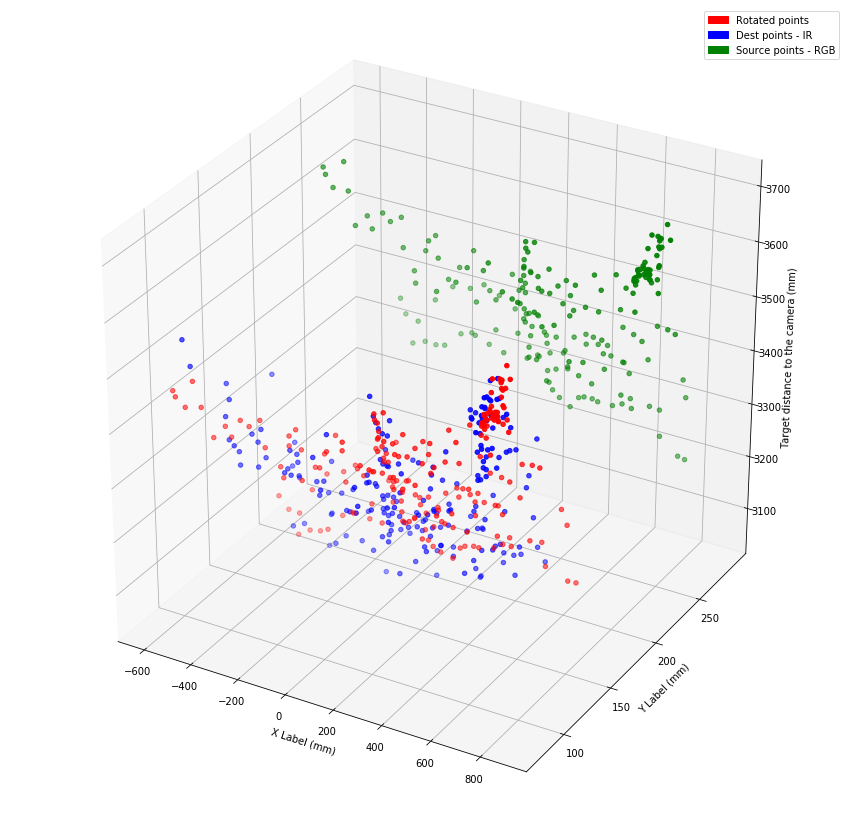

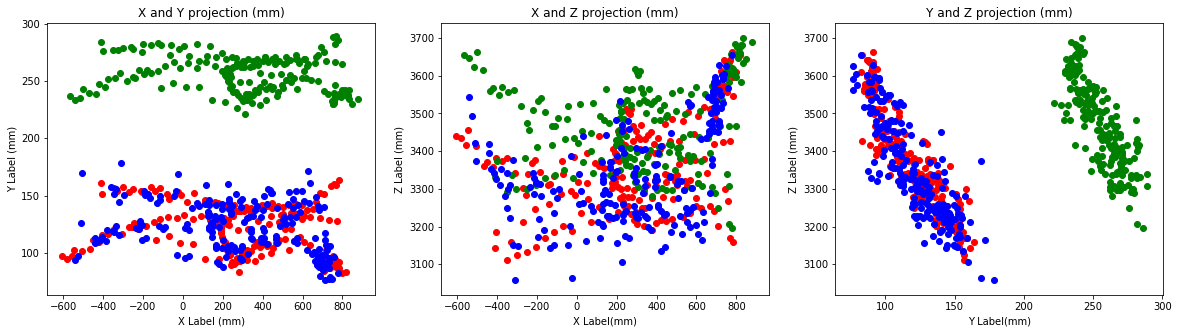

In [16]:
fig2 = plt.figure(figsize=(15,15))
ax2 = fig2.add_subplot(111, projection='3d')

red_patch = mpatches.Patch(color='red', label='Rotated points')
green_patch = mpatches.Patch(color='green', label='Source points - RGB')
blue_patch = mpatches.Patch(color='blue', label='Dest points - IR')
plt.legend(handles=[red_patch,blue_patch,green_patch])

ax2.set_xlabel('X Label (mm)')
ax2.set_ylabel('Y Label (mm)')
ax2.set_zlabel('Target distance to the camera (mm)')

ax2.scatter(transformed_points_rgbt[:,0],transformed_points_rgbt[:,1],transformed_points_rgbt[:,2], c='r')
ax2.scatter(objectPoints1[:,0],objectPoints1[:,1],objectPoints1[:,2], c='g')
ax2.scatter(objectPoints2[:,0],objectPoints2[:,1],objectPoints2[:,2], c='b')

fig_final, axs_f = plt.subplots(1,3,figsize=(20,5))

axs_f[0].scatter(transformed_points_rgbt[:,0],transformed_points_rgbt[:,1], c='r')
axs_f[0].scatter(objectPoints1[:,0],objectPoints1[:,1], c='g')
axs_f[0].scatter(objectPoints2[:,0],objectPoints2[:,1], c='b')
axs_f[0].set_xlabel('X Label (mm)')
axs_f[0].set_ylabel('Y Label (mm)')
axs_f[0].set_title('X and Y projection (mm)')

axs_f[1].scatter(transformed_points_rgbt[:,0],transformed_points_rgbt[:,2], c='r')
axs_f[1].scatter(objectPoints1[:,0],objectPoints1[:,2], c='g')
axs_f[1].scatter(objectPoints2[:,0],objectPoints2[:,2], c='b')
axs_f[1].set_xlabel('X Label(mm)')
axs_f[1].set_ylabel('Z Label (mm)')
axs_f[1].set_title('X and Z projection (mm)')

axs_f[2].scatter(transformed_points_rgbt[:,1],transformed_points_rgbt[:,2], c='r')
axs_f[2].scatter(objectPoints1[:,1],objectPoints1[:,2], c='g')
axs_f[2].scatter(objectPoints2[:,1],objectPoints2[:,2], c='b')
axs_f[2].set_xlabel('Y Label(mm)')
axs_f[2].set_ylabel('Z Label (mm)')
axs_f[2].set_title('Y and Z projection (mm)')

plt.show()

<h1>Calculate transformations (from Thermal to RGB) </h1> 

In [17]:
T_21, distances, i=icp(objectPoints2,objectPoints1)
transformed_points_trgb=transformation(objectPoints2,T_21)
rmse=mean_squared_error(objectPoints1,transformed_points_trgb,squared=False)
rmse
# print(np.mean(distances))

61.013291704543676

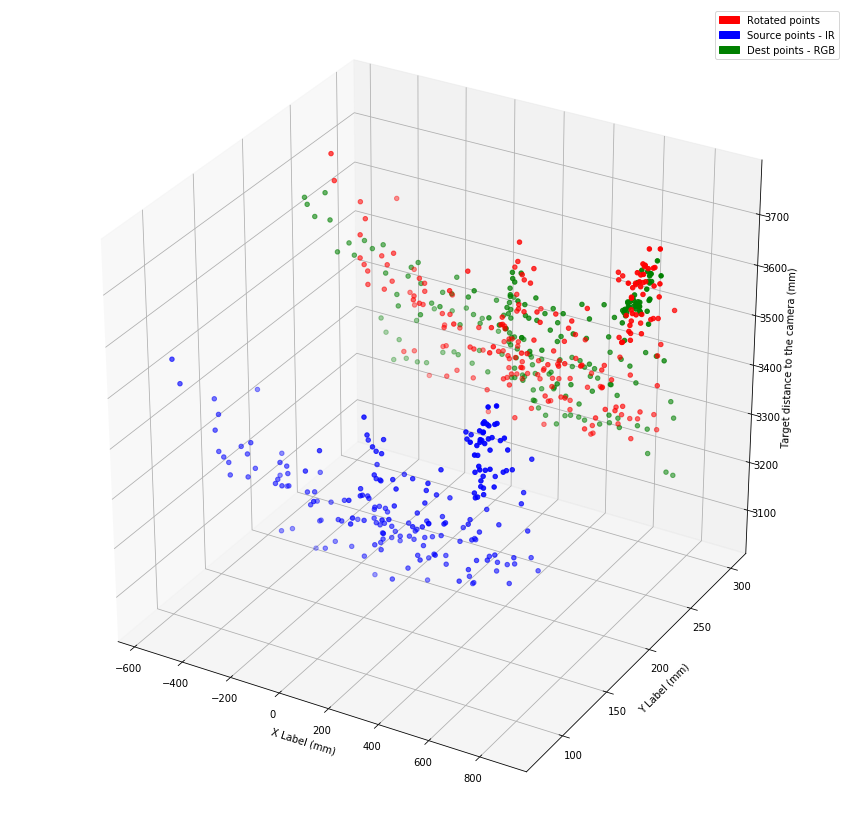

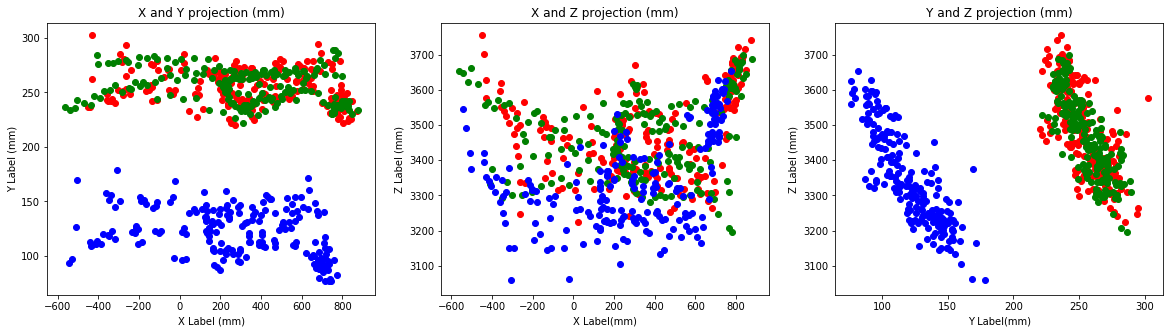

In [19]:
fig2 = plt.figure(figsize=(15,15))
ax2 = fig2.add_subplot(111, projection='3d')

red_patch = mpatches.Patch(color='red', label='Rotated points')
green_patch = mpatches.Patch(color='green', label='Dest points - RGB')
blue_patch = mpatches.Patch(color='blue', label='Source points - IR')
plt.legend(handles=[red_patch,blue_patch,green_patch])

ax2.set_xlabel('X Label (mm)')
ax2.set_ylabel('Y Label (mm)')
ax2.set_zlabel('Target distance to the camera (mm)')

ax2.scatter(transformed_points_trgb[:,0],transformed_points_trgb[:,1],transformed_points_trgb[:,2], c='r')
ax2.scatter(objectPoints1[:,0],objectPoints1[:,1],objectPoints1[:,2], c='g')
ax2.scatter(objectPoints2[:,0],objectPoints2[:,1],objectPoints2[:,2], c='b')

fig_final, axs_f = plt.subplots(1,3,figsize=(20,5))

axs_f[0].scatter(transformed_points_trgb[:,0],transformed_points_trgb[:,1], c='r')
axs_f[0].scatter(objectPoints1[:,0],objectPoints1[:,1], c='g')
axs_f[0].scatter(objectPoints2[:,0],objectPoints2[:,1], c='b')
axs_f[0].set_xlabel('X Label (mm)')
axs_f[0].set_ylabel('Y Label (mm)')
axs_f[0].set_title('X and Y projection (mm)')

axs_f[1].scatter(transformed_points_trgb[:,0],transformed_points_trgb[:,2], c='r')
axs_f[1].scatter(objectPoints1[:,0],objectPoints1[:,2], c='g')
axs_f[1].scatter(objectPoints2[:,0],objectPoints2[:,2], c='b')
axs_f[1].set_xlabel('X Label(mm)')
axs_f[1].set_ylabel('Z Label (mm)')
axs_f[1].set_title('X and Z projection (mm)')

axs_f[2].scatter(transformed_points_trgb[:,1],transformed_points_trgb[:,2], c='r')
axs_f[2].scatter(objectPoints1[:,1],objectPoints1[:,2], c='g')
axs_f[2].scatter(objectPoints2[:,1],objectPoints2[:,2], c='b')
axs_f[2].set_xlabel('Y Label(mm)')
axs_f[2].set_ylabel('Z Label (mm)')
axs_f[2].set_title('Y and Z projection (mm)')

plt.show()